# Setup

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xml.etree.ElementTree as ET
import re

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#!pip3 install -U scikit-learn

In [ ]:
##!python

In [ ]:
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

#Libraries for NLP
import nltk

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# from google.colab import files
# uploaded = files.upload()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Combine social histories of each patient into a unified record

In [ ]:
def read_xml_file(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        xml_string = file.read()
    return xml_string.strip()

In [ ]:
def extract_social_history(text):
  # Split the sections
  history = split_sections(text)

  # delete last one in history, as 90% of the time it is the title of the next section
  if history:
    history = history[:history.rfind('\n')]
    #print("FOUND: " + history)

  return history

In [ ]:
def split_sections(text):
  keywordsList = ["\nsocial history", "\nsh", "\nsocial and family history",
                  "\tsocial history", "\tsh", "\tsocial and family history",
                  " social history", " sh", " social and family history"]
  colonSplit = text.split(':') # Split everything into a list cut by cols
  for i in range(0, len(colonSplit)-1):
    ele = colonSplit[i]

    # if len(ele) >= 25:
    #   ele = ele[-25:]

    ele = ele.strip().lower()
    # see if ele is a social history.
    for key in keywordsList:
      if len(ele) > len(key) and ele[-len(key):].lower() == key:
          return colonSplit[i+1]

  return None

In [ ]:
# Parse patient files for a bunch of key words
# Lives, living, etc followed by "with" or " w " before next period.
# Wife, husband, married, marriage, spouse all are automatic yes
# word alone marks as living alone

# do it twice, once with entire text, once with social history

def analyze_living_situation(text):
    living_keywords = ["live ", "lives", "living", "resides"]
    alone_keywords = ["alone", "independently"]
    family_keywords = ["wife", "husband", "spouse", "married", "roommate", "partner"]

    sentences = text.split('.')
    result = None

    for sentence in sentences:
        if any(word in sentence.lower() for word in living_keywords):
            if any(word in sentence.lower() for word in alone_keywords):
                return ["Alone", sentence]
            if any(word in sentence.lower() for word in family_keywords):
                return ["With Others", sentence]
            if "with" in sentence.lower():
              result = ["With Others", sentence]

        elif any(word in sentence.lower() for word in family_keywords):
          result = ["With Others", sentence]
        elif "alone" in sentence.lower():
          result = ["Alone", sentence]

    return result

In [ ]:
# Each patient file is marked ###-##
# where the first three numbrers denote the patient
patient_id_set = set()
# Going to organize the db by patient

def process_folder(folder_path):
    data = []

    patient_files = {}



    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
          patient_id = filename.split('-')[0]
          file_id = filename.split('-')[1].split('.')[0]
          if patient_id not in patient_files:
            patient_files[patient_id] = {'Text': None}

          patient_id_set.add(patient_id)

          # print(folder_path + filename)
          xml_string = read_xml_file(folder_path + filename)
          text = ET.fromstring(xml_string).find('.//TEXT').text.strip()
          social_history = extract_social_history(text)
          patient_files[patient_id][file_id] = {'Text': text, 'Social History': social_history}

          # Adding Whether they live alone or with others
          # Based off Social history only
          if 'Lives (SH)' not in patient_files[patient_id]:
            patient_files[patient_id]["Lives (SH)"] = None
          if patient_files[patient_id]["Lives (SH)"] == None and patient_files[patient_id][file_id]["Social History"] != None:
            patient_files[patient_id]["Lives (SH)"] = analyze_living_situation(patient_files[patient_id][file_id]["Social History"])
          # based off entire text
          if 'Lives (Text)' not in patient_files[patient_id]:
            patient_files[patient_id]["Lives (Text)"] = None
          if patient_files[patient_id]["Lives (Text)"] == None and patient_files[patient_id][file_id]["Text"] != None:
            patient_files[patient_id]["Lives (Text)"] = analyze_living_situation(patient_files[patient_id][file_id]["Text"])



    shList = []

    # get average SH lengths
    for patient in patient_files:
      averageLen = 0
      totalLen = 0
      numEntries = 0
      shText = ""

      for filename in ["01","02","03","04","05"]:

        if filename in patient_files[patient]:
          sh = patient_files[patient][filename]["Social History"]
          if sh != None:
            totalLen += len(sh)
            numEntries += 1
            shText += sh
      if numEntries > 0:
        averageLen = totalLen/numEntries

      shList.append(shText)


      patient_files[patient]["SH Average Len"] = averageLen




    df = pd.DataFrame(patient_files)
    return df, patient_files, shList



## Process folder to create dataframe

In [ ]:
folder_path = '/content/drive/MyDrive/Project3_data/'
df, pf, shText = process_folder(folder_path)

df.head(15)

,331,332,295,352,241,302,321,222,249,364,...,314,301,272,365,225,229,276,298,399,328
Text,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
04,{'Text': 'Record date: 2080-11-09 MANAMANA IN...,{'Text': 'Record date: 2097-10-31 INTERNAL ...,{'Text': 'Record date: 2081-03-08 ...,{'Text': 'Record date: 2070-11-29 HISTORY OF...,{'Text': 'Record date: 2076-12-11 ...,{'Text': 'Record date: 2084-04-03 Beaumont Ho...,{'Text': 'Record date: 2072-03-08 Date 3/08/7...,{'Text': 'Record date: 2097-06-13 ...,{'Text': 'Record date: 2075-12-14 CARDIOLO...,{'Text': 'Record date: 2124-11-23 ...,...,{'Text': 'Record date: 2094-12-08 Neurolog...,{'Text': 'Record date: 2079-10-31 SECTIONS OF...,{'Text': 'Record date: 2094-12-10 Internal Me...,{'Text': 'Record date: 2074-06-09 Reason for ...,{'Text': 'Record date: 2095-12-04 CARDIOLOG...,NaN,{'Text': 'Record date: 2063-01-17 GIPSO...,{'Text': 'Record date: 2083-01-12 86 yo male ...,{'Text': 'Record date: 2071-11-23 Visit Not...,{'Text': 'Record date: 2078-06-14 Medicine C...
Lives (SH),None,"[Alone, Living independently with supportive ...",None,"[With Others, Lives with her husband]",None,None,None,None,"[With Others, His wife recently had quite a ...",None,...,"[With Others, Widowed, lives with son]","[With Others, Lives in Florida with wife]",None,"[With Others, \nOccupation Floor Covering...","[With Others, \n Lives with wife in Lagrange...",None,"[With Others, \n\n He lives with his family]",None,None,"[Alone, \n\nWidow Performer, lives alone in ..."
Lives (Text),"[With Others, \n\nLives with wife who is well ...","[Alone, Living independently with supportive ...",None,"[With Others, Lives with her husband]",None,"[With Others, Her husband visited\never thre...","[With Others, Single, lives with her sister]",None,"[With Others, On the other hand, he is a lit...","[With Others, \n\nSocial Hx: Married, two chil...",...,"[With Others, Widowed, lives with son]","[With Others, \n\n\n\nPMH: OSA, obesity, ost...","[With Others, 5mg QD\n\nASA\n\nFosinopril 40mg...","[With Others, \n\n\nPMH \n\nDM\nObesity s/p R...","[With Others, \n\n\n\tPast medical history:\n ...",None,"[With Others, After consultation with you, w...","[With Others, \n\n(3)\tWife mentions patient ...","[With Others, \n\n\n\nPMHx:\n\n-stroke as abo...","[Alone, \n\n\n\n\nREVIEW OF SYSTEMS\n\nGeneral..."
02,{'Text': 'Record date: 2079-01-24 Mr. Sparks ...,{'Text': 'Record date: 2094-08-11 INTERNA...,{'Text': 'Record date: 2080-05-21 Vascula...,{'Text': 'Record date: 2069-10-22 EDVISIT^631...,{'Text': 'Record date: 2074-12-05 ...,{'Text': 'Record date: 2083-04-03 Beaumont H...,{'Text': 'Record date: 2069-07-03 R foot ulce...,{'Text': 'Record date: 2095-03-27 Wt 198 146...,{'Text': 'Record date: 2073-04-02 INTERNA...,{'Text': 'Record date: 2121-08-10 SMH...,...,{'Text': 'Record date: 2093-06-12 Dutch 19 T...,{'Text': 'Record date: 2077-02-01 ...,{'Text': 'Record date: 2093-06-30 NAME: ...,{'Text': 'Record date: 2071-04-11 ...,{'Text': 'Record date: 2094-05-20 CARDIOLOG...,{'Text': 'Record date: 2081-04-13 CARDIOLOGY ...,"{'Text': 'Record date: 2060-07-28 GIPSON, ...",{'Text': 'Record date: 2081-07-17 FREDERICK J...,{'Text': 'Record date: 2070-03-24 Neurology C...,{'Text': 'Record date: 2077-07-14 Educare-Fa...
01,{'Text': 'Record date: 2078-12-06 Mr. Sparks ...,{'Text': 'Record date: 2094-01-29 INTERNA...,{'Text': 'Record date: 2078-12-13 Vascular ...,{'Text': 'Record date: 2062-02-13 ...,{'Text': 'Record date: 2074-07-05 ...,{'Text': 'Record date: 2082-07-04 Beaumont H...,{'Text': 'Record date: 2068-01-04 ...,{'Text': 'Record date: 2094-12-09 ...,{'Text': 'Record date: 2071-11-20 Patient Nam...,{'Text': 'Record date: 2118-07-04 INTERN ADMI...,...,{'Text': 'Record date: 2092-09-21 MEDIQUIK...,{'Text': 'Record date: 2074-10-01 Office Note ...,{'Text': 'Record date: 2093-01-13 Uriah Olive...,{'Text': 'Record date: 2066-02-07 ...,{'Text': 'Record date: 2093-07-05 CARDIOLOG...,{'Text': 'R

In [ ]:
len(shText)

296

In [ ]:
print(shText)

['   Retired flying instructor; worked in private airfield. Appears younger than stated age.\n', '\n\nContinues to get out to the American Senior Center, except on one day.  In the spring, she continues to get out, goes to bingo and continues to be very active.  She gets out everyday.  She is very active.  Daughters are very involved with her.  We have gone over in detail on this visit managing all of her issues.  Continues to go to the club at Dekalb three times a week.  \n\n\n\nContinues to get out to the American Senior Center, except on one day. Living independently with supportive family. Three daughters and 2 sons are very involved with her.\n\n', '', '  Ms. Riley is from Mexico.  She has lived here for the last 15 years. Lives with her husband. Denies any tobacco or alcohol.\n\n\n  Ms. Riley is from Mexico.  She has lived here for the last 15 years and denies tobacco or alcohol.  \n', '', '', '\nLives in Estherville w/ sister.  Translator.', '', '\n\n   He has four children and 

In [ ]:
# find number of patients with 0 social history recorded
nonShPatients = 0

for patient in df:
  if df[patient]["SH Average Len"] <= 0:
    nonShPatients += 1
print("shText len = " + str(len(shText)))
print("nonShPatients = " + str(nonShPatients))
shText = list(filter(lambda x: x != "", shText)) # just to make sure lol
print("shText len = " + str(len(shText)))

shText len = 296
nonShPatients = 75
shText len = 221


# Exploratory Analysis

In [ ]:
text = shText

In [ ]:
#Function to get top words and counts
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [ ]:
#Removing stop words and developing a list of top words in abstracts
def topWordList(text, title):
  cv = CountVectorizer(stop_words='english')
  words, word_val = get_top_n_words(n_top_words=15, count_vectorizer=cv, text_data=text)
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.bar(words, word_val)
  ax.set_xticklabels(words, rotation='vertical');
  ax.set_title(title);
  ax.set_xlabel('Word');
  ax.set_ylabel('Number of occurences');
  plt.show()
  print(range(len(words)))

<ipython-input-146-c76bacd4d34a>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation='vertical');


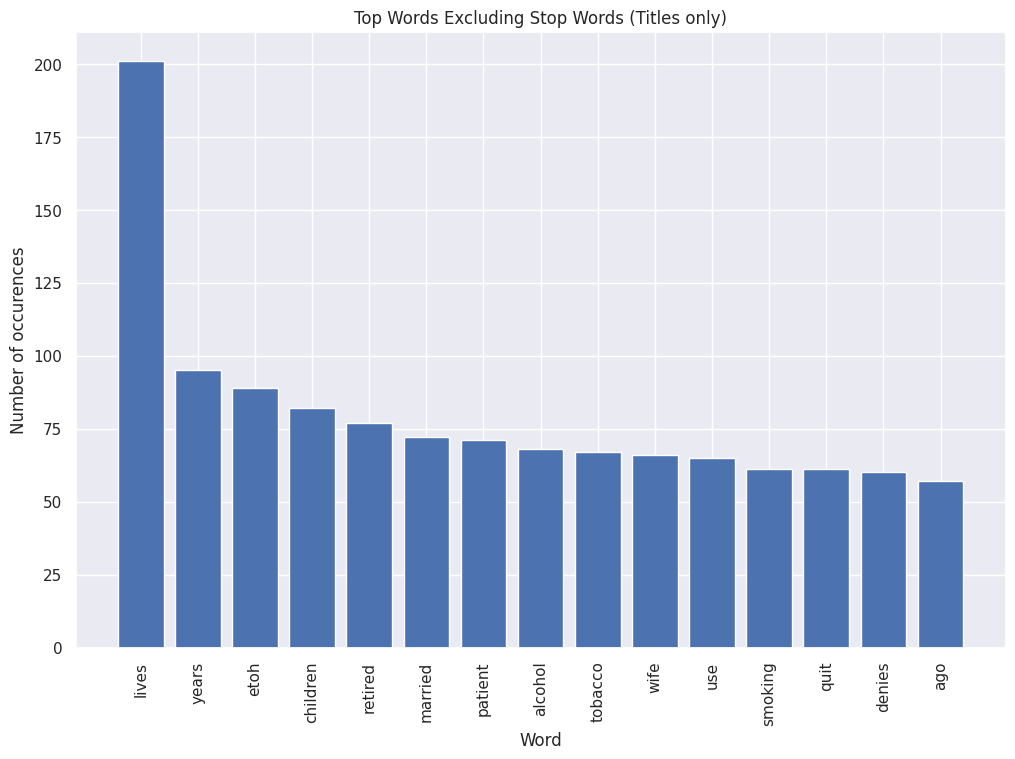

range(0, 15)


In [ ]:
######### TITLES
topWordList(text, "Top Words Excluding Stop Words (Titles only)")

# Topic Modeling

## Preprocessing for LDA

In [ ]:
#Making a class for both tokenization and lemmatization
lemm = nltk.WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Storing all training text in a list
#text = list(text)

# Calling the overwritten count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

## LDA (Sklearn)

In [ ]:
#number of topics
n_topics=5

In [ ]:
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online',
                                learning_offset=50., random_state=0, verbose =0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        print(type(temp_vector_sum))
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))
    return top_words

In [ ]:
# for i in tf:
#   s = 0
#   s+=i
#   print(type(s))

In [ ]:
# Printing words from each topic
top_n_words = get_top_n_words(20, lda_keys, tf, tf_vectorizer)

for i in range(len(top_n_words)):
    print("Topic {}:\n ".format(i), top_n_words[i] + "\n")

<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
Topic 0:
  life etoh doe married drug year daughter tobacco use patient drink retired child alcohol smoke history family husband smoking son

Topic 1:
  married 18 health rock good officer age work son unchanged facility etoh edema editor father employed end engineer family engineering

Topic 2:
  mg tablet po 20 bid month parent 80 negative occupation dr physical uc 90 married ro medication calcium cancer going

Topic 3:
  life year child quit ago retired wife etoh denies drug work smoking patient alcohol tobacco use married past 30 pack

Topic 4:
  po qd reveals exam extremity life rate rash chest rhythm today regular week m 70 think care mr s2 blood



In [ ]:
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)
# Takes a while just fyi

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 221 samples in 0.000s...
[t-SNE] Computed neighbors for 221 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 221 / 221
[t-SNE] Mean sigma: 0.036835
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.943924
[t-SNE] KL divergence after 1000 iterations: 0.031606


In [ ]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])

        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
# Colourmap for the visualization
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

#Getting the mean of the topic vector for the visualization
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

##Creating the t-SNE plot
plot = figure(title="t-SNE Clustering of {} LDA Topics for Patient Level Social History".format(n_topics), width=600, height=600)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1],
                  text=top_3_words_lda[t], text_color='black')
    plot.add_layout(label)

show(plot)

<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
doc_topic = lda.transform(tf)

for n in range(20):
    topic_most_pr = doc_topic[n].argmax()
    print("Document #{} - topic: {}\n".format(n,topic_most_pr))

Document #0 - topic: 3

Document #1 - topic: 0

Document #2 - topic: 3

Document #3 - topic: 3

Document #4 - topic: 0

Document #5 - topic: 0

Document #6 - topic: 0

Document #7 - topic: 3

Document #8 - topic: 3

Document #9 - topic: 0

Document #10 - topic: 0

Document #11 - topic: 0

Document #12 - topic: 4

Document #13 - topic: 0

Document #14 - topic: 0

Document #15 - topic: 3

Document #16 - topic: 3

Document #17 - topic: 0

Document #18 - topic: 3

Document #19 - topic: 0



## Advanced Analysis of LDA

My main goal is to
1. Find the most relevant articles for each topic so they can be used as the links for further research
2. maybe find another way to list the most relevant articles such as using rating or views (later)

In [ ]:
# making a dataframe from the document-topic matrix
doc_topic_df = pd.DataFrame(data=doc_topic)
doc_topic_df

,0,1,2,3,4
0,0.033760,0.034076,0.033680,0.864826,0.033658
1,0.973787,0.006539,0.006534,0.006576,0.006565
2,0.012135,0.011897,0.011848,0.952146,0.011974
3,0.068480,0.066976,0.066992,0.730085,0.067467
4,0.942114,0.014412,0.014435,0.014638,0.014401
...,...,...,...,...,...
216,0.003771,0.003734,0.984953,0.003768,0.003774
217,0.006043,0.005917,0.005913,0.976216,0.005911
218,0.009764,0.009719,0.009656,0.961124,0.009737
219,0.025842,0.025158,0.025135,0.898719,0.025147


In [ ]:
# printing the top 'n' articles for each topic
for (columnName, columnData) in doc_topic_df.items():
    n = 3
    print('Topic #', columnName)
    sorted_topic = pd.DataFrame(data=columnData.values).sort_values(by=0, ascending=False)
    sorted_topic.columns = [columnName]
    print(sorted_topic[:n])

    # store IDs and titles of top articles in a dataframe
    ids = sorted_topic[:n].index

Topic # 0
            0
65   0.993145
49   0.992320
187  0.988115
Topic # 1
            1
93   0.978109
134  0.597381
98   0.470135
Topic # 2
            2
216  0.984953
73   0.909992
87   0.200000
Topic # 3
            3
162  0.992438
110  0.987339
156  0.983189
Topic # 4
            4
29   0.992897
175  0.977454
116  0.886496


0    119
3     91
4      7
2      2
1      2
Name: count, dtype: int64

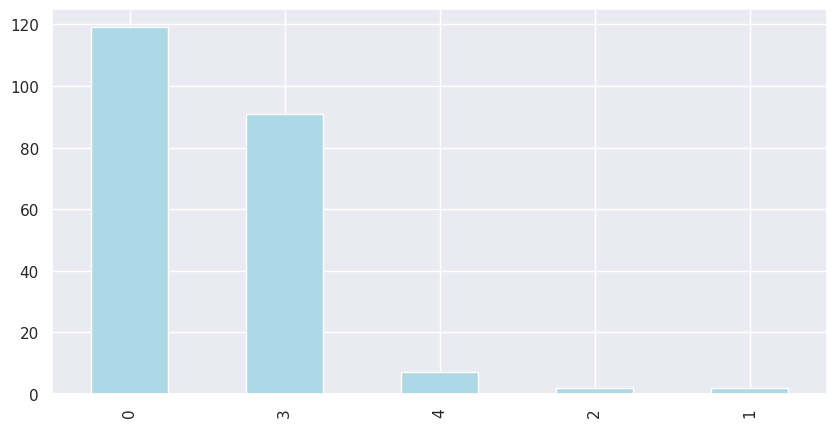

In [ ]:
#plotting the distribution of documents over each topic
sns.set(rc={'figure.figsize':(10,5)})
doc_topic_df.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#store the distributions in a dataframe
distribution = doc_topic_df.idxmax(axis=1).value_counts()
distribution

# Extra Stuff

In [ ]:
t1 = "\n bruh \n SOCIAL HISTORY:\nOriginally from .  Widowed 42 years, 4 children, 4 grandchildren.  Works in TLC as a nurse.  No tobacco/alcohol/drugs.  \n\n ALLERGIES:  NKDA"
t2 = "\n SOCIAL HISTORY: Originally from .  Widowed 42 years, 4 children, 4 grandchildren.  Works in TLC as a nurse.  No tobacco/alcohol/drugs. ALLERGIES:  NKDA"

In [ ]:
print(extract_social_history(t2))

None


In [ ]:
t1.lower()

'\n bruh \n social history:\noriginally from .  widowed 42 years, 4 children, 4 grandchildren.  works in tlc as a nurse.  no tobacco/alcohol/drugs.  \n\n allergies:  nkda'